# TCC Focos de Queimadas no Cerrado
## Entendimento inicial da base INMET + BDQueimadas

Este caderno implementa a etapa 1 da análise: inspeção e auditoria de qualidade dos arquivos ano a ano no padrão `data/dataset/inmet_bdq_{ANO}_cerrado.csv`. O foco aqui é medir:

1. Proporção de HAS_FOCO por ano.
2. Ocorrência de valores sentinela em qualquer coluna numérica: -999, -9999, 999, 9999.
3. Entre as linhas com foco, quantas contêm sentinelas negativos (-999 ou -9999).

Observação de parsing: os CSVs usam vírgula como separador decimal em diversas colunas. Usaremos `decimal=','` no carregamento e coerção numérica laxa para auditoria.


## Sumário

1. [Configuração e imports](#configuracao-e-imports)
2. [Parâmetros do projeto e diretórios](#parametros-do-projeto-e-diretorios)
3. [Funções de descoberta e leitura](#funcoes-de-descoberta-e-leitura)
4. [Coerção numérica e sentinelas](#coercao-numerica-e-sentinelas)
5. [Métricas por ano](#metricas-por-ano)
6. [Pipeline de auditoria](#pipeline-de-auditoria)
7. [Execução e persistência do resumo](#execucao-e-persistencia-do-resumo)
8. [Visualizações rápidas](#visualizacoes-rapidas)
9. [Sanity check com 2003](#sanity-check-com-2003)
10. [Próximos passos](#proximos-passos)


## 1. Configuração e imports

In [2]:
from __future__ import annotations

from pathlib import Path
from dataclasses import dataclass
from typing import Iterable, Dict, List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Importa utilitários do projeto (como o notebook está em src/, o import direto funciona)
from utils import loadConfig, get_path, ensure_dir  # <- usando utils do projeto

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)


## 2. Parâmetros do projeto e diretórios

In [3]:
# Carrega config e resolve raízes de forma determinística
cfg = loadConfig(create_dirs=True)

# Tenta obter a raiz e o dataset do config; se a chave específica não existir, cai no fallback
try:
    PROJECT_ROOT: Path = get_path("paths", "root")
except Exception:
    # Fallback robusto: se o notebook está em <root>/src, PROJECT_ROOT é o pai de CWD
    PROJECT_ROOT = Path.cwd().parent.resolve()

# Resolve DATASET_DIR pela config, com fallback para <root>/data/dataset
DATASET_DIR: Path | None = None
try:
    # Caso você já tenha definido no config algo como paths.data.dataset
    DATASET_DIR = get_path("paths", "data", "dataset")
except Exception:
    pass

if DATASET_DIR is None:
    # Fallback padrão do projeto
    candidate = PROJECT_ROOT / "data" / "dataset"
    DATASET_DIR = candidate.resolve()

# Reports sempre em <root>/reports/eda (ou ajuste no seu config e substitua aqui por get_path)
REPORTS_DIR = ensure_dir(PROJECT_ROOT / "reports" / "eda")

# Padrão de nome dos arquivos ano a ano
FILENAME_PATTERN = "inmet_bdq_*_cerrado.csv"

# Valida e informa caminhos efetivos
if not DATASET_DIR.exists():
    raise FileNotFoundError(
        "Diretório de datasets não encontrado.\n"
        f"Tentado: {DATASET_DIR}\n"
    )

print("[OK] PROJECT_ROOT:", PROJECT_ROOT)
print("[OK] DATASET_DIR :", DATASET_DIR)
print("[OK] REPORTS_DIR :", REPORTS_DIR)


[OK] PROJECT_ROOT: D:\Projetos\TCC
[OK] DATASET_DIR : D:\Projetos\TCC\data\dataset
[OK] REPORTS_DIR : D:\Projetos\TCC\reports\eda


## 3. Funções de descoberta e leitura

In [4]:
def discover_year_files(dataset_dir: Path = DATASET_DIR, pattern: str = FILENAME_PATTERN) -> Dict[int, Path]:
    """
    Descobre arquivos no padrão inmet_bdq_{ANO}_cerrado.csv e mapeia {ano: caminho}.
    Critério: extrai o primeiro token AAAA do nome do arquivo.
    """
    mapping: Dict[int, Path] = {}
    for fp in dataset_dir.glob(pattern):
        digits = "".join(ch if ch.isdigit() else " " for ch in fp.stem).split()
        year = None
        for token in digits:
            if len(token) == 4:
                try:
                    y = int(token)
                    if 1900 <= y <= 2100:
                        year = y
                        break
                except ValueError:
                    pass
        if year is not None:
            mapping[year] = fp
    return dict(sorted(mapping.items()))


def read_year_csv(fp: Path) -> pd.DataFrame:
    """
    Lê um CSV consolidado do dataset.
    - separador: ','
    - decimal: ','
    - encoding: utf-8
    Mantém dtypes inferidos, sem substituir sentinelas.
    """
    df = pd.read_csv(
        fp,
        sep=",",
        decimal=",",
        encoding="utf-8",
        low_memory=False,
    )
    return df


## 4. Coerção numérica e sentinelas

In [5]:
# Conjunto de sentinelas
SENTINELS_NEG = {-999, -9999}
SENTINELS_POS = {999, 9999}
SENTINELS_ALL = SENTINELS_NEG | SENTINELS_POS

# Colunas explicitamente excluídas da coerção numérica para auditoria
EXCLUDE_NON_NUMERIC = {"DATA (YYYY-MM-DD)", "HORA (UTC)", "CIDADE", "cidade_norm", "ts_hour"}


def coerce_numeric_for_audit(df: pd.DataFrame, exclude: set[str] = EXCLUDE_NON_NUMERIC) -> pd.DataFrame:
    """
    Cria uma visão numérica das colunas possíveis para auditoria de sentinelas.
    - Exclui colunas sabidamente categóricas ou temporais em string.
    - Aplica to_numeric com errors='coerce' nas demais colunas não booleanas.
    Retorna um DataFrame alinhado ao índice original, contendo apenas colunas numéricas coeridas.
    """
    cols = [c for c in df.columns if c not in exclude]
    num = pd.DataFrame(index=df.index)
    for c in cols:
        ser = df[c]
        if pd.api.types.is_numeric_dtype(ser):
            num[c] = ser
        else:
            num[c] = pd.to_numeric(ser, errors="coerce")
    return num


## 5. Métricas por ano

In [6]:
@dataclass
class YearAudit:
    year: int
    rows_total: int
    focos: int
    nao_focos: int
    proporcao_foco: float
    rows_any_sentinel_all: int
    rows_any_sentinel_neg: int
    foco_rows_with_neg_sentinel: int
    pct_foco_with_neg_sentinel: float


def compute_year_metrics(df: pd.DataFrame, year: int) -> YearAudit:
    """
    Calcula as métricas pedidas para um ano específico.
    - proporção de HAS_FOCO
    - linhas com qualquer sentinela
    - linhas com sentinelas negativos
    - entre focos, quantas linhas possuem sentinelas negativos
    """
    if "HAS_FOCO" not in df.columns:
        raise KeyError(f"Coluna HAS_FOCO não encontrada no ano {year}")

    rows_total = len(df)
    focos = int((df["HAS_FOCO"] == 1).sum())
    nao_focos = rows_total - focos
    proporcao_foco = focos / rows_total if rows_total else 0.0

    num_view = coerce_numeric_for_audit(df)

    mask_any_all = num_view.isin(SENTINELS_ALL).any(axis=1)
    rows_any_sentinel_all = int(mask_any_all.sum())

    mask_any_neg = num_view.isin(SENTINELS_NEG).any(axis=1)
    rows_any_sentinel_neg = int(mask_any_neg.sum())

    foco_mask = (df["HAS_FOCO"] == 1)
    foco_rows_with_neg_sentinel = int((foco_mask & mask_any_neg).sum())
    pct_foco_with_neg_sentinel = (foco_rows_with_neg_sentinel / focos) if focos else 0.0

    return YearAudit(
        year=year,
        rows_total=rows_total,
        focos=focos,
        nao_focos=nao_focos,
        proporcao_foco=proporcao_foco,
        rows_any_sentinel_all=rows_any_sentinel_all,
        rows_any_sentinel_neg=rows_any_sentinel_neg,
        foco_rows_with_neg_sentinel=foco_rows_with_neg_sentinel,
        pct_foco_with_neg_sentinel=pct_foco_with_neg_sentinel,
    )


## 6. Pipeline de auditoria

In [7]:
def run_audit(dataset_dir: Path = DATASET_DIR, pattern: str = FILENAME_PATTERN) -> pd.DataFrame:
    """
    Executa o pipeline de auditoria para todos os arquivos identificados.
    Retorna um DataFrame com as métricas por ano, ordenado.
    """
    year_files = discover_year_files(dataset_dir, pattern)
    if not year_files:
        raise FileNotFoundError(f"Nenhum arquivo encontrado em {dataset_dir} com padrão {pattern}")

    audits: List[YearAudit] = []
    for year, fp in year_files.items():
        df = read_year_csv(fp)
        audit = compute_year_metrics(df, year)
        audits.append(audit)

    out = pd.DataFrame([a.__dict__ for a in audits]).sort_values("year").reset_index(drop=True)
    return out


## 7. Execução e persistência do resumo

In [8]:
summary_df = run_audit(DATASET_DIR, FILENAME_PATTERN)

# Ordena colunas para leitura
col_order = [
    "year",
    "rows_total",
    "focos",
    "nao_focos",
    "proporcao_foco",
    "rows_any_sentinel_all",
    "rows_any_sentinel_neg",
    "foco_rows_with_neg_sentinel",
    "pct_foco_with_neg_sentinel",
]
summary_df = summary_df[col_order]

# Exibe
display(summary_df.style.format({
    "proporcao_foco": "{:.4f}",
    "pct_foco_with_neg_sentinel": "{:.4f}",
}))

# Persiste
out_path = REPORTS_DIR / "summary_sentinels_by_year.csv"
summary_df.to_csv(out_path, index=False, encoding="utf-8")
print(f"[WRITE] {out_path}")


,year,rows_total,focos,nao_focos,proporcao_foco,rows_any_sentinel_all,rows_any_sentinel_neg,foco_rows_with_neg_sentinel,pct_foco_with_neg_sentinel
0,2003,198028,1054,196974,0.0053,122534,122516,564,0.5351
1,2004,198244,994,197250,0.0050,131644,131632,774,0.7787
2,2006,302130,1236,300894,0.0041,146762,146638,30,0.0243
3,2007,1181586,5902,1175684,0.0050,550032,549604,38,0.0064
4,2008,2000366,7222,1993144,0.0036,878678,877950,144,0.0199
5,2009,2185516,5076,2180440,0.0023,953636,952756,144,0.0284
6,2011,2298104,6990,2291114,0.0030,1093624,1092700,508,0.0727
7,2012,2442676,8450,2434226,0.0035,1197650,1196646,604,0.0715
8,2013,2505914,6926,2498988,0.0028,1265462,1264408,776,0.1120
9,2014,2510432,8132,2502300,0.0032,1308628,1307810,1308,0.1608


[WRITE] D:\Projetos\TCC\reports\eda\summary_sentinels_by_year.csv


## 12. Funções para breakdown por coluna e ano

In [8]:
from typing import Optional

def sentinel_column_breakdown(
    df: pd.DataFrame,
    year: int,
    sentinels_neg: set[int] = SENTINELS_NEG,
    exclude: set[str] = EXCLUDE_NON_NUMERIC,
) -> pd.DataFrame:
    """
    Retorna um DataFrame no formato long com contagens de sentinelas negativos por coluna:
      - col: nome da coluna
      - count_all_neg: linhas com sentinela negativo nessa coluna
      - count_focus_neg: linhas com foco e sentinela negativo nessa coluna
      - count_nonfocus_neg: linhas sem foco e com sentinela negativo nessa coluna
      - pct_all_neg_over_rows: count_all_neg / total de linhas
      - pct_focus_neg_over_focus: count_focus_neg / total de focos
    """
    if "HAS_FOCO" not in df.columns:
        raise KeyError("Coluna HAS_FOCO não encontrada")

    rows_total = len(df)
    focos_total = int((df["HAS_FOCO"] == 1).sum())

    num = coerce_numeric_for_audit(df, exclude=exclude)
    foco_mask = (df["HAS_FOCO"] == 1)

    # Considera apenas colunas presentes na visão numérica
    cols = list(num.columns)

    data = []
    for c in cols:
        ser = num[c]
        mask_neg = ser.isin(sentinels_neg)
        count_all_neg = int(mask_neg.sum())
        count_focus_neg = int((mask_neg & foco_mask).sum())
        count_nonfocus_neg = count_all_neg - count_focus_neg

        pct_all = count_all_neg / rows_total if rows_total else 0.0
        pct_focus = (count_focus_neg / focos_total) if focos_total else 0.0

        data.append({
            "year": year,
            "col": c,
            "rows_total": rows_total,
            "focos_total": focos_total,
            "count_all_neg": count_all_neg,
            "count_focus_neg": count_focus_neg,
            "count_nonfocus_neg": count_nonfocus_neg,
            "pct_all_neg_over_rows": pct_all,
            "pct_focus_neg_over_focus": pct_focus,
        })

    out = pd.DataFrame(data).sort_values(["year", "count_all_neg"], ascending=[True, False]).reset_index(drop=True)
    return out


def run_sentinel_breakdown_all_years(
    dataset_dir: Path = DATASET_DIR,
    pattern: str = FILENAME_PATTERN,
    sentinels_neg: set[int] = SENTINELS_NEG,
    exclude: set[str] = EXCLUDE_NON_NUMERIC,
) -> pd.DataFrame:
    """
    Executa o breakdown por coluna para todos os anos disponíveis.
    Retorna um DataFrame long concatenando todos os anos.
    """
    year_files = discover_year_files(dataset_dir, pattern)
    if not year_files:
        raise FileNotFoundError(f"Nenhum arquivo encontrado em {dataset_dir} com padrão {pattern}")

    all_rows = []
    for year, fp in year_files.items():
        df = read_year_csv(fp)
        br = sentinel_column_breakdown(df, year, sentinels_neg=sentinels_neg, exclude=exclude)
        all_rows.append(br)

    return pd.concat(all_rows, ignore_index=True)


## 13. Breakdown por coluna e por ano

In [9]:
col_breakdown_df = run_sentinel_breakdown_all_years(DATASET_DIR, FILENAME_PATTERN)
display(col_breakdown_df.head(20))

# Salva artefato completo
out_cols_csv = REPORTS_DIR / "sentinel_neg_breakdown_by_year_column.csv"
col_breakdown_df.to_csv(out_cols_csv, index=False, encoding="utf-8")
print(f"[WRITE] {out_cols_csv}")

# Mostra, para cada ano, as 10 colunas com mais sentinelas negativos
topk = (
    col_breakdown_df
    .sort_values(["year", "count_all_neg"], ascending=[True, False])
    .groupby("year")
    .head(10)
    .reset_index(drop=True)
)

display(topk.head(30))

out_top_csv = REPORTS_DIR / "sentinel_neg_breakdown_top10_by_year.csv"
topk.to_csv(out_top_csv, index=False, encoding="utf-8")
print(f"[WRITE] {out_top_csv}")


,year,col,rows_total,focos_total,count_all_neg,count_focus_neg,count_nonfocus_neg,pct_all_neg_over_rows,pct_focus_neg_over_focus
0,2003,RADIACAO GLOBAL (KJ/m²),198028,1054,116286,518,115768,0.587220,0.491461
1,2003,"VENTO, RAJADA MAXIMA (m/s)",198028,1054,13122,54,13068,0.066263,0.051233
2,2003,"VENTO, DIREÇÃO HORARIA (gr) (° (gr))",198028,1054,12962,54,12908,0.065455,0.051233
3,2003,"VENTO, VELOCIDADE HORARIA (m/s)",198028,1054,12958,54,12904,0.065435,0.051233
4,2003,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",198028,1054,1746,22,1724,0.008817,0.020873
5,2003,"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORAR...",198028,1054,1562,8,1554,0.007888,0.007590
6,2003,"UMIDADE RELATIVA DO AR, HORARIA (%)",198028,1054,36,0,36,0.000182,0.000000
7,2003,TEMPERATURA DO PONTO DE ORVALHO (°C),198028,1054,30,0,30,0.000151,0.000000
8,2003,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",198028,1054,28,0,28,0.000141,0.000000
9,2003,ANO,198028,1054,0,0,0,0.000000,0.000000


[WRITE] D:\Projetos\TCC\reports\eda\sentinel_neg_breakdown_by_year_column.csv


,year,col,rows_total,focos_total,count_all_neg,count_focus_neg,count_nonfocus_neg,pct_all_neg_over_rows,pct_focus_neg_over_focus
0,2003,RADIACAO GLOBAL (KJ/m²),198028,1054,116286,518,115768,0.587220,0.491461
1,2003,"VENTO, RAJADA MAXIMA (m/s)",198028,1054,13122,54,13068,0.066263,0.051233
2,2003,"VENTO, DIREÇÃO HORARIA (gr) (° (gr))",198028,1054,12962,54,12908,0.065455,0.051233
3,2003,"VENTO, VELOCIDADE HORARIA (m/s)",198028,1054,12958,54,12904,0.065435,0.051233
4,2003,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",198028,1054,1746,22,1724,0.008817,0.020873
5,2003,"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORAR...",198028,1054,1562,8,1554,0.007888,0.007590
6,2003,"UMIDADE RELATIVA DO AR, HORARIA (%)",198028,1054,36,0,36,0.000182,0.000000
7,2003,TEMPERATURA DO PONTO DE ORVALHO (°C),198028,1054,30,0,30,0.000151,0.000000
8,2003,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",198028,1054,28,0,28,0.000141,0.000000
9,2003,ANO,198028,1054,0,0,0,0.000000,0.000000


[WRITE] D:\Projetos\TCC\reports\eda\sentinel_neg_breakdown_top10_by_year.csv


In [10]:
breakdown_df = run_sentinel_breakdown_all_years(
    dataset_dir=DATASET_DIR,
    pattern=FILENAME_PATTERN,
    sentinels_neg=SENTINELS_NEG,
    exclude=EXCLUDE_NON_NUMERIC,
)

out_path = REPORTS_DIR / "sentinel_breakdown_by_year_col.csv"
ensure_dir(REPORTS_DIR)
breakdown_df.to_csv(out_path, index=False, encoding="utf-8")
print(f"[WRITE] {out_path}")
display(breakdown_df.head())


[WRITE] D:\Projetos\TCC\reports\eda\sentinel_breakdown_by_year_col.csv


,year,col,rows_total,focos_total,count_all_neg,count_focus_neg,count_nonfocus_neg,pct_all_neg_over_rows,pct_focus_neg_over_focus
0,2003,RADIACAO GLOBAL (KJ/m²),198028,1054,116286,518,115768,0.587220,0.491461
1,2003,"VENTO, RAJADA MAXIMA (m/s)",198028,1054,13122,54,13068,0.066263,0.051233
2,2003,"VENTO, DIREÇÃO HORARIA (gr) (° (gr))",198028,1054,12962,54,12908,0.065455,0.051233
3,2003,"VENTO, VELOCIDADE HORARIA (m/s)",198028,1054,12958,54,12904,0.065435,0.051233
4,2003,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",198028,1054,1746,22,1724,0.008817,0.020873


C:\Users\julia\AppData\Local\Temp\ipykernel_13336\2980333796.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x["count_all_neg"].sum() / x["rows_total"].sum())


,pct_missing_global
col,
RADIACAO GLOBAL (KJ/m²),0.401569
"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",0.024889
"VENTO, DIREÇÃO HORARIA (gr) (° (gr))",0.011794
"VENTO, RAJADA MAXIMA (m/s)",0.008769
"VENTO, VELOCIDADE HORARIA (m/s)",0.008687
TEMPERATURA DO PONTO DE ORVALHO (°C),0.007477
"UMIDADE RELATIVA DO AR, HORARIA (%)",0.007130
"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",0.003720
"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",0.000966


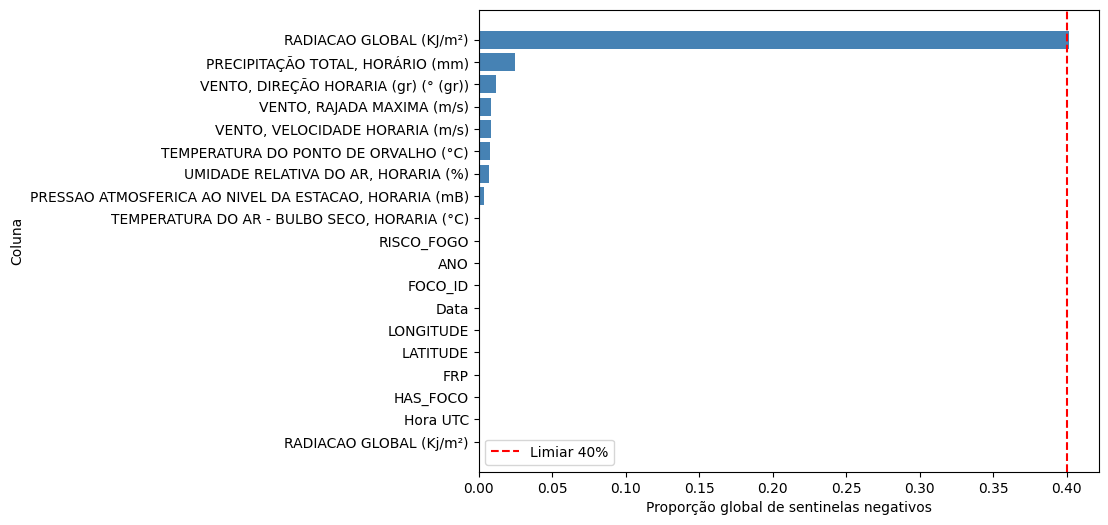

In [12]:
COL_MISSING_THRESHOLD = 0.40  # 40%, ajustável

col_missing_global = (
    breakdown_df
    .groupby("col")
    .apply(lambda x: x["count_all_neg"].sum() / x["rows_total"].sum())
    .sort_values(ascending=False)
    .rename("pct_missing_global")
)

display(col_missing_global.to_frame())

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(col_missing_global.index, col_missing_global.values, color="steelblue")
ax.axvline(COL_MISSING_THRESHOLD, color="red", linestyle="--", label=f"Limiar {COL_MISSING_THRESHOLD:.0%}")
ax.set_xlabel("Proporção global de sentinelas negativos")
ax.set_ylabel("Coluna")
ax.invert_yaxis()
ax.legend()
plt.show()


In [13]:
extreme_cols = col_missing_global[col_missing_global > COL_MISSING_THRESHOLD].index.tolist()
print("Colunas com missing extremo:", extreme_cols)


Colunas com missing extremo: ['RADIACAO GLOBAL (KJ/m²)']


In [14]:
CRITICAL_COLS = [
    "HAS_FOCO",  # se existir
    "RISCO_FOGO",  # se existir
    "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",
    "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",
    "TEMPERATURA DO PONTO DE ORVALHO (°C)",
    "UMIDADE RELATIVA DO AR, HORARIA (%)",
    "VENTO, VELOCIDADE HORARIA (m/s)",
]

YEAR_COL_THRESHOLD = 0.20  # 20% de missing em qualquer coluna crítica

crit = breakdown_df[breakdown_df["col"].isin(CRITICAL_COLS)]

year_max_missing = (
    crit.groupby("year")["pct_all_neg_over_rows"]
    .max()
    .rename("max_pct_missing_critical")
    .sort_index()
)

display(year_max_missing.to_frame())

bad_years = year_max_missing[year_max_missing > YEAR_COL_THRESHOLD].index.tolist()
good_years = year_max_missing[year_max_missing <= YEAR_COL_THRESHOLD].index.tolist()

print("Anos considerados ruins (baseado em colunas criticas):", bad_years)
print("Anos considerados bons:", good_years)


,max_pct_missing_critical
year,
2003,0.065435
2004,0.000958
2006,0.042267
2007,0.017273
2008,0.005329
2009,0.023233
2011,0.050060
2012,0.033292
2013,0.029774


Anos considerados ruins (baseado em colunas criticas): []
Anos considerados bons: [2003, 2004, 2006, 2007, 2008, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


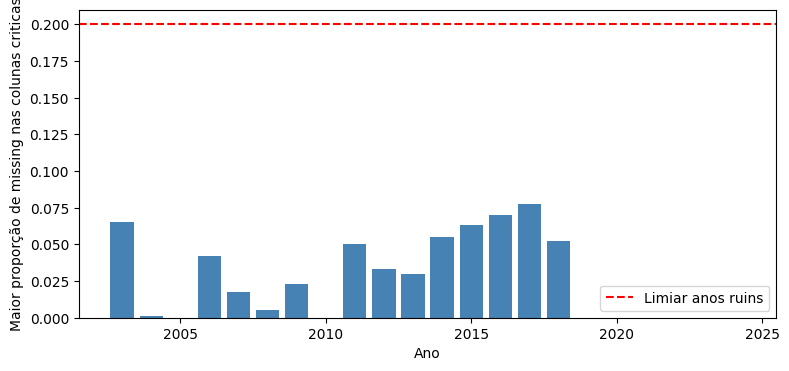

In [15]:
fig, ax = plt.subplots(figsize=(9, 4))
ax.bar(year_max_missing.index, year_max_missing.values, color="steelblue")
ax.axhline(YEAR_COL_THRESHOLD, color="red", linestyle="--", label="Limiar anos ruins")
ax.set_xlabel("Ano")
ax.set_ylabel("Maior proporção de missing nas colunas criticas")
ax.legend()
plt.show()


In [1]:
def apply_sentinels_to_nan_inplace(
    df: pd.DataFrame,
    exclude: set[str] = EXCLUDE_NON_NUMERIC,
    sentinels: set[int] = SENTINELS_ALL,
) -> pd.DataFrame:
    for c in df.columns:
        if c in exclude:
            continue
        if not pd.api.types.is_numeric_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], errors="coerce")
        df[c] = df[c].where(~df[c].isin(sentinels), np.nan)
    return df


def load_all_years_clean(dataset_dir: Path = DATASET_DIR, pattern: str = FILENAME_PATTERN) -> pd.DataFrame:
    year_files = discover_year_files(dataset_dir, pattern)
    if not year_files:
        raise FileNotFoundError(f"Nenhum arquivo encontrado em {dataset_dir} com padrão {pattern}")

    frames = []
    for year, fp in year_files.items():
        df = read_year_csv(fp)

        if "ANO" not in df.columns:
            df["ANO"] = year

        apply_sentinels_to_nan_inplace(df)

        # cria ts_hour aqui mesmo
        if "ts_hour" not in df.columns:
            df["ts_hour"] = pd.to_datetime(
                df["DATA (YYYY-MM-DD)"].astype(str) + " " + df["HORA (UTC)"].astype(str),
                errors="coerce",
            )

        frames.append(df)

    base_df = pd.concat(frames, ignore_index=True)
    return base_df


base_df = load_all_years_clean()


NameError: name 'EXCLUDE_NON_NUMERIC' is not defined

In [ ]:
def interpolate_by_group_time(
    df: pd.DataFrame,
    cols: List[str],
    group_cols: List[str],
    order_col: str = "ts_hour",
) -> pd.DataFrame:
    out = df.sort_values(group_cols + [order_col]).copy()
    for c in cols:
        if c not in out.columns:
            continue
        if not pd.api.types.is_numeric_dtype(out[c]):
            continue
        out[c] = (
            out
            .groupby(group_cols)[c]
            .apply(lambda s: s.interpolate(limit_direction="both"))
        )
    return out


In [ ]:
METEO_COLS = [
    "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",
    "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",
    "RADIACAO GLOBAL (KJ/m²)",
    "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",
    "TEMPERATURA DO PONTO DE ORVALHO (°C)",
    "UMIDADE RELATIVA DO AR, HORARIA (%)",
    "VENTO, DIREÇÃO HORARIA (gr) (° (gr))",
    "VENTO, RAJADA MAXIMA (m/s)",
    "VENTO, VELOCIDADE HORARIA (m/s)",
]

group_cols_full = [c for c in ["CIDADE"] if c in base_df.columns]

df_full_imputed = interpolate_by_group_time(
    base_df,
    cols=[c for c in METEO_COLS if c in base_df.columns],
    group_cols=group_cols_full or ["ANO"],  # fallback tosco se faltar cidade
)

VARIANTS_DIR = get_path("datasets") / "model_variants"
ensure_dir(VARIANTS_DIR)
df_full_imputed.to_parquet(VARIANTS_DIR / "dataset_full_imputed.parquet", index=False)
print("[WRITE] dataset_full_imputed.parquet")


In [ ]:
cols_to_drop = [c for c in extreme_cols if c in base_df.columns]
print("Dropando colunas extremas:", cols_to_drop)

df_drop_extreme_cols = base_df.drop(columns=cols_to_drop)

df_drop_extreme_cols = interpolate_by_group_time(
    df_drop_extreme_cols,
    cols=[c for c in METEO_COLS if c in df_drop_extreme_cols.columns],
    group_cols=group_cols_full or ["ANO"],
)

df_drop_extreme_cols.to_parquet(VARIANTS_DIR / "dataset_drop_extreme_cols.parquet", index=False)
print("[WRITE] dataset_drop_extreme_cols.parquet")


In [ ]:
df_drop_bad_years = base_df[base_df["ANO"].isin(good_years)].copy()

# Também removemos colunas extremas aqui, para manter coerência
df_drop_bad_years = df_drop_bad_years.drop(columns=[c for c in extreme_cols if c in df_drop_bad_years.columns])

df_drop_bad_years = interpolate_by_group_time(
    df_drop_bad_years,
    cols=[c for c in METEO_COLS if c in df_drop_bad_years.columns],
    group_cols=group_cols_full or ["ANO"],
)

df_drop_bad_years.to_parquet(VARIANTS_DIR / "dataset_drop_bad_years.parquet", index=False)
print("[WRITE] dataset_drop_bad_years.parquet")
